In [61]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_churn = pd.read_csv("./통신고객이탈.CSV",engine="python")
ds_churn.head()
warnings.filterwarnings('ignore')

In [54]:
# 결측치 없다.
data.isnull().sum()

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

In [55]:
ds_churn["CHURN"].replace(to_replace = "Active", value = 0, inplace =True)
ds_churn["CHURN"].replace(to_replace = "Churned", value = 0, inplace =True)

In [56]:
ds_churn_dummy = pd.get_dummies(ds_churn.drop(["CHURN", "CUSTOMER_ID"], axis = 1))
ds_churn_dummy.head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER_F,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,31,33.33,6,218,379.8,9,21.6,366,632.4,1,...,0,0,0,0,0,0,1,0,0,0
1,27,30.87,10,373,656.4,11,28.0,411,810.4,0,...,0,0,0,0,0,0,1,0,0,0
2,27,49.40,11,260,582.0,0,0.0,265,614.1,0,...,0,0,0,0,0,0,1,0,0,0
3,61,48.60,1,294,661.8,14,101.5,326,844.0,0,...,0,0,0,0,0,0,1,0,0,0
4,52,56.03,0,221,555.6,7,25.0,274,673.0,1,...,0,0,0,0,0,0,1,0,0,0


In [62]:
ds_churn_scaled = scale(ds_churn_dummy)
ds_churn_scaled = pd.DataFrame(ds_churn_scaled, columns = ds_churn_dummy.columns)
ds_churn_scaled["CHURN"] = ds_churn["CHURN"]
ds_churn_scaled.head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER_F,...,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None,CHURN
0,-0.030604,-0.069958,0.949112,-0.032834,-0.617357,-0.432263,-0.755024,0.079015,-0.783880,0.943527,...,-0.109405,-0.104257,-0.373773,-0.269563,-0.128037,0.915393,-0.5848,-0.360572,-0.046424,Active
1,-0.335827,-0.243451,2.091732,0.651830,-0.080674,-0.307456,-0.579614,0.259163,-0.458260,-1.059853,...,-0.109405,-0.104257,-0.373773,-0.269563,-0.128037,0.915393,-0.5848,-0.360572,-0.046424,Active
2,-0.335827,1.063386,2.377387,0.152687,-0.225031,-0.993897,-1.347031,-0.325316,-0.817357,-1.059853,...,-0.109405,-0.104257,-0.373773,-0.269563,-0.128037,0.915393,-0.5848,-0.360572,-0.046424,Active
3,2.258568,1.006966,-0.479163,0.302872,-0.070196,-0.120245,1.434855,-0.081116,-0.396795,-1.059853,...,-0.109405,-0.104257,-0.373773,-0.269563,-0.128037,0.915393,-0.5848,-0.360572,-0.046424,Active
4,1.571816,1.530970,-0.764818,-0.019583,-0.276254,-0.557071,-0.661838,-0.289287,-0.709610,0.943527,...,-0.109405,-0.104257,-0.373773,-0.269563,-0.128037,0.915393,-0.5848,-0.360572,-0.046424,Active


In [63]:
# random seed 고정 매번 실행 시 같은 값을 얻음
np.random.seed(seed = 1234)
# 0.7(70%) 보다 작으면 True: train 데이터, 아니면 False: test 데이터
msk = np.random.rand(ds_churn_scaled.shape[0], ) < 0.7
ds_churn_train = ds_churn_scaled[msk]
ds_churn_test = ds_churn_scaled[~msk]
# train/test 데이터의 목표변수 설명변수 지정
ds_churn_train_y = ds_churn_train["CHURN"]
ds_churn_train_x = ds_churn_train.drop("CHURN", axis = 1, inplace = False)
ds_churn_test_y = ds_churn_test["CHURN"]
ds_churn_test_x = ds_churn_test.drop("CHURN", axis = 1, inplace = False)
# train 데이터와 test 데이터 크기
print("train data X size : {}".format(ds_churn_train_x.shape))
print("train data Y size : {}".format(ds_churn_train_y.shape))
print("test data X size : {}".format(ds_churn_test_x.shape))
print("test data Y size : {}".format(ds_churn_test_y.shape))

train data X size : (635, 33)
train data Y size : (635,)
test data X size : (295, 33)
test data Y size : (295,)


In [64]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(ds_churn_train_x, ds_churn_train_y)

# 훈련 데이터 정확도
print("Accuracy on training set:{:.3f}".format(rf_uncustomized.score(ds_churn_train_x,
                                                                      ds_churn_train_y)))
print("Accuracy on training set:{:3f}".format(rf_uncustomized.score(ds_churn_test_x,
                                                                      ds_churn_test_y)))

Accuracy on training set:0.992
Accuracy on training set:0.854237


In [65]:
# 현재 생성된 랜덤 포레스트 모델의 옵션 확인
rf_uncustomized

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [66]:
# train 데이터셋 스케일 조정
ds_churn_train_x_scaled= scale(ds_churn_train_x, axis=0)
# test 데이터셋 스케일 조정
ds_churn_test_x_scaled =scale(ds_churn_test_x, axis = 0)
# 스케일이 변경된 X변수 확인
pd.DataFrame(ds_churn_train_x_scaled, columns = ds_churn_train_x.columns).head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER_F,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,-0.061287,-0.066658,0.936779,-0.050954,-0.622843,-0.431938,-0.777862,0.069711,-0.778293,0.958347,...,-0.467771,-0.097668,-0.105577,-0.365963,-0.259281,-0.132771,0.916831,-0.590081,-0.36319,-0.039715
1,-0.366521,-0.240702,2.073082,0.618542,-0.088273,-0.309382,-0.601091,0.247156,-0.454921,-1.043463,...,-0.467771,-0.097668,-0.105577,-0.365963,-0.259281,-0.132771,0.916831,-0.590081,-0.36319,-0.039715
2,-0.366521,1.070294,2.357157,0.130457,-0.232062,-0.983441,-1.374462,-0.328554,-0.811538,-1.043463,...,-0.467771,-0.097668,-0.105577,-0.365963,-0.259281,-0.132771,0.916831,-0.590081,-0.36319,-0.039715
3,1.464884,1.072417,0.084552,0.255718,-0.416436,-0.922163,-0.496134,0.310247,-0.286151,-1.043463,...,2.137797,-0.097668,-0.105577,-0.365963,-0.259281,-0.132771,0.916831,-0.590081,-0.36319,-0.039715
4,-0.137596,-0.139530,0.936779,0.851786,0.053197,-0.248104,0.083895,0.558670,-0.279066,0.958347,...,-0.467771,-0.097668,-0.105577,-0.365963,-0.259281,-0.132771,0.916831,-0.590081,-0.36319,-0.039715


In [67]:
# 새로운 랜덤 포레스트 모델 생성
rf_scaled = RandomForestClassifier(random_state=1234)
rf_scaled.fit(ds_churn_train_x_scaled,ds_churn_train_y)
# 훈련 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_scaled.score(ds_churn_train_x_scaled,ds_churn_train_y)))
# 테스트 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(rf_scaled.score(ds_churn_test_x_scaled,ds_churn_test_y)))

Accuracy on training set: 0.992
Accuracy on test set: 0.864


In [69]:
# 트리 수 최대값 : 30; 1~30까지 실행
n_iter_tree = 30
# train 및 테스트 정확도 결과 저장용
train_accuracy =  []
test_accuracy = []
# 트리 최대수(1~30)별로 랜덤 포레스트 모델 생성 및 정확도값 저장
for n_tree in range(n_iter_tree):
    rf1 = RandomForestClassifier(n_estimators=n_tree+1, random_state=1234)
    rf1.fit(ds_churn_train_x_scaled,ds_churn_train_y)
    train_accuracy.append(rf1.score(ds_churn_train_x_scaled,ds_churn_train_y))
    test_accuracy.append(rf1.score(ds_churn_test_x_scaled,ds_churn_test_y))
# 저장된 모델의 train/ test 데이터 분류 정확도 테이블 생성
ds_accuracy1 = pd.DataFrame()
ds_accuracy1["NumberofTree"] = [n_tree + 1 for n_tree in range(n_iter_tree)]
ds_accuracy1["TrainAccuracy"]=train_accuracy
ds_accuracy1["TestAccuracy"]=test_accuracy

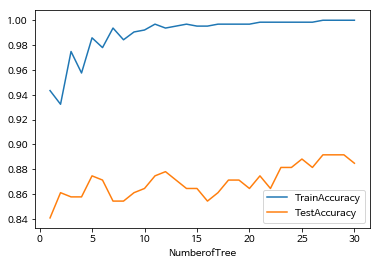

In [70]:
# 테이블 결과
ds_accuracy1
# 그래프생성 
# y축 - 정확도 x축 - Tree 개수
ds_accuracy1.set_index("NumberofTree",inplace=False).plot.line()

# 랜덤 포레스트 모델 Parameter 변경
- Criterion: 분리 기준 변경(gini, entropy)

In [72]:
# train 및 테스트 정확도 결과 저장용
train_accuracy =  []
test_accuracy = []
# 적용 가능한 criterion : gini, entropy
para_criterion = ["gini", "entropy"]
# para_criterion 별로 랜덤 포레스트 모델 생성 및 정확도값 저장
for criterion in para_criterion:
    rf2 = RandomForestClassifier(criterion= criterion, random_state=1234)
    rf2.fit(ds_churn_train_x_scaled,ds_churn_train_y)
    train_accuracy.append(rf2.score(ds_churn_train_x_scaled,ds_churn_train_y))
    test_accuracy.append(rf2.score(ds_churn_test_x_scaled,ds_churn_test_y))
# 저장된 모델의 train/ test 데이터 분류 정확도 테이블 생성
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["TrainAccuracy"]=train_accuracy
ds_accuracy2["TestAccuracy"]=test_accuracy

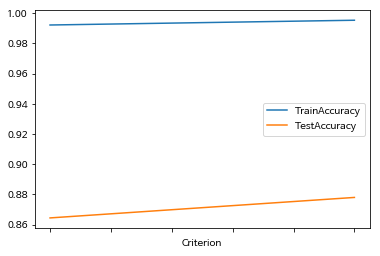

In [73]:
# 테이블 결과
ds_accuracy2
# 그래프생성
ds_accuracy2.set_index("Criterion",inplace=False).plot.line()

# 랜덤 포레스트 모델 Parameter 변경
- max_depth : 최대 깊이 변경

In [ ]:
# train 및 테스트 정확도 결과 저장용
train_accuracy =  []
test_accuracy = []
# 적용 가능한 criterion : gini, entropy
para_max_depth = [i+1 for i in range(10)]*2
n_iter_depth = 10
# criterion 10개씩 리스트 생성
para_criterion = ["gini"]*n_iter_depth + ["entropy"] * n_iter_depth
# criterion : gini, entropy & max_depth: 1~10까지 반복 실행
for (criterion,depth) in zip (para_criterion,para_max_depth):
    rf3 = RandomForestClassifier(criterion= criterion,max_depth = depth, random_state=1234)
    rf3.fit(ds_hmeq_train_x_scaled,ds_churn_train_y)
    train_accuracy.append(rf3.score(ds_hmeq_train_x_scaled,ds_hmeq_train_y))
    test_accuracy.append(rf3.score(ds_hmeq_test_x_scaled,ds_hmeq_test_y))
# 데이터 테이블로 저장
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["TrainAccuracy"]=train_accuracy
ds_accuracy3["TestAccuracy"]=test_accuracy